# Loop's inner workings

### Daniela del Río
### Thursday, April 24, 2025

This notebook is based on: `Error_calculation.ipynb`

Goals: 
1. Organize the code in a loop structure (iteration).
2. Inputs: distinct set of weights. Output: the error at every timepoint and the result from the error function.
3. Do one iteration of channel weight updating using PyBADS.

Note I am only using the first run/scan which are 316 entries. This run has condition 4 for left and right, that is:
- 4 Left far unattend
- 4 Right far attend

In [2]:
import math
import os
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats 

# commands to create high-resolution figures with large labels, credits Erin McKiernan
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting


### Defining a series of functions for the models's inner workings!

In [4]:
# Input: frequencies, conditions, numbering_L and numbering_R,
# Output the filenames of interest.
def filenames_fun(f0 = 100, f_end=340, f_increment=30,
                  conditions=[1, 2, 3, 4],
                  numbering_L = [f"{i:02d}" for i in range(1, 10)],
                  numbering_R = [f"{i:02d}" for i in range(10, 19)]): # Left (01–09) and Right (10–18)
    '''
    Function that creates the filenames of the files from the EventFolder.
    Input: frequencies, conditions, numbering_L and numbering_R,
    Output the filenames of interest.
    '''
    frequencies = list(range(f0, f_end+1, f_increment))        # 100 to 280 in steps of 30
    
    # Loop and generate filenames
    filenames = []
    
    # Handle L side
    for num, freq in zip(numbering_L, frequencies):
        for cond in conditions:
            fname = f"FreqAP08_{num}_L{freq}_{cond}.txt"
            filenames.append(fname)
            
    # Handle R side (same frequencies!)
    for num, freq in zip(numbering_R, frequencies):
        for cond in conditions:
            fname = f"FreqAP08_{num}_R{freq}_{cond}.txt"
            filenames.append(fname)
            
    # Filter to get only filenames that end with "_4.txt"
    files_cond1 = [f for f in filenames if f.endswith('_1.txt')]
    files_cond2 = [f for f in filenames if f.endswith('_2.txt')]
    files_cond3 = [f for f in filenames if f.endswith('_3.txt')]
    files_cond4 = [f for f in filenames if f.endswith('_4.txt')]

    return files_cond1, files_cond2, files_cond3, files_cond4

In [5]:
def first_binary_line(event_file_path, TR = 1.5, run_len = 316):# , nruns=8):
    '''
    Function that given the event's file path, it extracts the first line.
    Input: event_file_path
    Output the 3 time vectors in seconds [3 entries], TR space [3 entries] and the timeseries [run_len entries].
        1. Original space. original3
        2. Converted space. transformed3_indices
        3. Matrix with the whole timeseries. binary_vector
    Note: If you want to consider more than 1 run, this is the function that has to be changed.
    '''
    # total_TRs = run_len * nruns # = 2528  # Replace with actual value from `3dinfo -nt`
    original3 = [] # Original is in seconds
    transformed3 = [] # This is in TR space
    binary_vector = np.zeros(run_len) # total_TRs
    
    with open(event_file_path, "r") as f:
        for run_index, line in enumerate(f):
            if run_index == 0:
                line = line.strip()
                # if "*" in line:
                #     continue  # Skip lines with '*'
                # if not line:
                #     continue  # Skip empty lines
                # try:
                times = np.asarray([float(t) for t in line.split()])
                # except ValueError:
                #     continue  # Skip invalid lines just in case
                run_offset = (run_index) * run_len # run_index -1?

                tr_indices = [int(t / TR) + run_offset for t in times]
                for idx in tr_indices:
                    binary_vector[idx] = 1
                original3.append(times)
                transformed3.append(tr_indices)
            else:
                break

    return np.asarray(original3), np.asarray(transformed3), np.asarray(binary_vector)

In [6]:

def stim_times_fun(filenames_cond, folder = "Session1/EventFiles"):
    '''
    Function that given the filenames for a specific condition, it extracts the first line for all those files
    Input: filenames_cond
    Output the 3 time vectors in seconds [3 entries], TR space [3 entries] and the timeseries [run_len entries] for ALL the files of a given condition.
        1. Original space. original3
        2. Converted space. transformed3_indices
        3. Matrix with the whole timeseries. binary_vector
    Note: If you want to consider more than 1 run, this function might require some changes.
    Note 2: Additionally, I think that this function can handle only 1 condition, say condition LXXX_4, and RXXX_4 presented in the first run.
    '''
    time_s_cond = [] # original3_cond4
    time_TR_cond = [] # transformed3_cond4
    binary_matrix_cond = []
    
    for fname in filenames_cond:
        fpath = os.path.join(folder, fname)
        
        try:
            t_s_vec, t_TR_vec, bin_vec = first_binary_line(fpath)
            time_s_cond.append(t_s_vec[0])
            time_TR_cond.append(t_TR_vec[0])
            binary_matrix_cond.append(bin_vec)
        
        except FileNotFoundError as e:
            print(f"Skipping: {e}")
    return time_s_cond, time_TR_cond, binary_matrix_cond

In [7]:
# files_cond1, files_cond2, files_cond3, files_cond4 = filenames_fun()
# folder = "Session1/EventFiles"

# print("Input: ", files_cond4)

# time_s_cond4, time_TR_cond4, binary_matrix_cond4 = stim_times_fun(files_cond4, folder)

# print("Output: ")
# print(time_s_cond4)
# print(time_TR_cond4)
# print(np.asarray(binary_matrix_cond4).shape)
# print("The following value should be less than 316: ", max([max(l) for l in time_TR_cond4]))

### Implementing the mechanistic model

Obtain the scalar value output for every stimulus. This will pair every stimulus to a scalar value.

$y \ = \ \sum_{i=1}^n \ \Big(\delta_L \cdot w_{i,L} \cdot c_i(s) \ + \ \delta_R \cdot w_{i,R}\cdot c_i(s) \Big) \ + \ \epsilon$

In [9]:
###################################################################################
################### CODE FOR THE MECHANISTIC MODEL ################################
def channel(x, mu=1, sigma=1):
    ''' Defines a single channel function based on a normal distribution. c
    '''
    return (np.exp(-(x-mu)**2/(2*sigma**2)))/(sigma*np.sqrt(2*np.pi))
    

def scalar_value(stimulus, weights, mus, sigmas):
    ''' Applies the channel function to a single stimulus, c=c(s)
    '''
    channel_values = np.asarray([channel(stimulus, mus[i], sigmas[i]) for i in range(n_channels)])
    y = np.sum(weights * channel_values)
    return y


def yy_all_stim(weights_left, weights_right, n_TR_timepoints, mus, sigmas,
                stimuli_freqs, stimuli_LR, stimuli_3values):
    # This function pairs all the stimulus with their scalar value through yy_vec
    # Additionally, it obtains the timeseries with the scalar values for the stimuli
    length = len(stimuli_freqs)
    yy_vec = np.zeros(length) # Vector of scalar values depending on the stimuli presented on stimuli_freqs
    yy_timeseries = np.zeros(n_TR_timepoints) # Timeseries of zeros and scalar values
    
    for i in range(length): # Cycle that obtains all the scalar values associated with every stimulus.
        stimulus_freq = stimuli_freqs[i]
        
        if stimuli_LR[i] == "L":
            yy_vec[i] = scalar_value(stimulus_freq, weights_left, mus, sigmas)
        elif stimuli_LR[i] == "R":
            yy_vec[i] = scalar_value(stimulus_freq, weights_right, mus, sigmas)
        else:
            print("There was an error in the stimuli_LR variable.")

        for stimuli_arg in stimuli_3values[i]: # This for loop stores the scalar value of that stimulus in the timeseries
            yy_timeseries[stimuli_arg] += yy_vec[i]

    return yy_timeseries, yy_vec
###################################################################################
################### MORE CODE FOR THE MODEL ################################

# In the following function is where the weights change.
# NOTE YOU ARE ASSUMMING ALL THE OTHHER yy_all_stim INPUT VARIABLES ARE GLOBAL.
# AS WELL AS hrf. THIS IS BAD PRACTICE!
def single_iteration(weights):
    ''' This function takes as input some weights and outputs the scalar error value.
    '''
    weights_left, weights_right = weights[:9], weights[9:]
    # print(len(weights_left))
    # print(len(weights_right))
    yy_timeseries, yy_vec = yy_all_stim(weights_left, weights_right, n_TR_timepoints, mus, sigmas, stimuli_freqs, stimuli_LR, stimuli_3values)
    BOLD_predicted = np.convolve(yy_timeseries, hrf)[:n_TR_timepoints]
    
    # function that receives 2 datasets and obtains the mean squared error.
    err = mean_squared_error(BOLD_predicted, BOLD_measured_voxel1) #scalar value
    return err # BOLD_predicted #yy_timeseries, yy_vec

def single_iteration_BOLD(weights):
    ''' This function takes as input some weights and outputs the scalar error value.
    '''
    weights_left, weights_right = weights[:9], weights[9:]
    # print(len(weights_left))
    # print(len(weights_right))
    yy_timeseries, yy_vec = yy_all_stim(weights_left, weights_right, n_TR_timepoints, mus, sigmas, stimuli_freqs, stimuli_LR, stimuli_3values)
    BOLD_predicted = np.convolve(yy_timeseries, hrf)[:n_TR_timepoints]
    return BOLD_predicted # BOLD_predicted #yy_timeseries, yy_vec


def HRF(t, A = 5, alpha_1 = 6, alpha_2 = 16, beta_1 = 1, beta_2 = 1, c = 1/6):
    ''' Hemodynamic response function (HRF) as defined in Friston 1998.
    '''
    numerator_1 = t**(alpha_1 - 1)*beta_1**(alpha_1) * np.exp(-beta_1*t)
    numerator_2 = t**(alpha_2 - 1)*beta_2**(alpha_2) * np.exp(-beta_2*t)
    return A * (numerator_1/math.gamma(alpha_1) - c*numerator_2/math.gamma(alpha_2))


###################################################################################
################### FUNCTIONS FOR LOADING THE REAL DATA ################################

def load_voxel_data(file_path):
# Prompt for ChatGPT: Create code whose input is the txt file with entries like the one below. Every row is a different voxel. There is a total of 2929 voxels. The first 3 columns are the coordinates of that voxel. The next entries are the values of that voxel as a time series. What data structure would you suggest for saving this information and why?
# Suggested the use of a dictionary and the following code:
    voxel_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            coords = tuple(map(float, parts[:3]))  # (x, y, z)
            time_series = np.array(list(map(float, parts[3:])))
            voxel_dict[coords] = time_series
    return voxel_dict

# Given a dictionary of data, this function extracts the timeseries for a single voxel given the run_len
def data_single_voxel(voxel_data, run1_length = 317, key1 = (-57.0, -5.5, 37.5)):
    voxel1 = voxel_data[key1] # Time series of a specific voxel
    voxel1_run1 = voxel1[:run1_length]
    return voxel1_run1
###################################################################################
################### ABCD ################################

### Implementation

In [11]:
# # Code for importing the real BOLD.
n_TR_timepoints = 316 # 2528
folder = "Session1/"
fname = "FreqAP08_masked_errts_from_nuisssance_regressors_session1.txt"
fpath = os.path.join(folder, fname)
voxel_data = load_voxel_data(fpath)
BOLD_measured_voxel1 = data_single_voxel(voxel_data, n_TR_timepoints, key1 = (-57.0, -5.5, 37.5))

# Import the real stimuli
files_cond1, files_cond2, files_cond3, files_cond4 = filenames_fun()
folder = "Session1/EventFiles"

time_s_cond4, time_TR_cond4, binary_matrix_cond4 = stim_times_fun(files_cond4, folder)

In [12]:
# Use a loop structure to implement the model.
# Create a function that does it. What are you initializing? What will be inside the loop?
# The thing is, all these values don't have to be initialized every single time the simulation runs.

n_channels = 9
# n_TR_timepoints = 316 # 2528
TR = 1.5 # in seconds. This is the sampling interval. See notes on Friday, April 18, 2025, specifically Goal 2.

# What's the difference between np.asarray and np.array?
# See here: https://stackoverflow.com/questions/14415741/what-is-the-difference-between-np-array-and-np-asarray
timeaxis_s = np.asarray([i*TR for i in range(n_TR_timepoints)]) # time
timeaxis_min = timeaxis_s/60

# Stimulus
n_freqs = 9
stimuli_aux = [100+i*30 for i in range(n_freqs)]
stimuli_freqs = np.concatenate((stimuli_aux,stimuli_aux))
stimuli_L_aux = ["L" for i in range(n_freqs)]
stimuli_R_aux = ["R" for i in range(n_freqs)]
stimuli_LR = np.concatenate((stimuli_L_aux,stimuli_R_aux))
stimuli_3values = time_TR_cond4


# Intitializing the HRF
index_for_sec_30 = 22
t_hrf = timeaxis_s[:index_for_sec_30]
hrf = HRF(t_hrf)

# Parameters that define the channels
# weights_left = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
# weights_right = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])


# Initializing the weights:
amplitude = 300
weights_left = [amplitude*(rd.random()*2-1) for i in range(n_channels)] # Values in the [-1, 1] range.
weights_right = [amplitude*(rd.random()*2-1) for i in range(n_channels)] # Values in the [-1, 1] range.

weights = np.concatenate((weights_left, weights_right))
# NOTE YOU ARE ASSUMMING ALL THE OTYHER yy_all_stim INPUT VARIABLES ARE GLOBAL.
err = single_iteration(weights)
print(err)
print(max(weights_left))
print(min(weights_left))
# yy_timeseries, yy_vec = yy_all_stim(n_timepoints, stimuli_freqs, stimuli_LR, stimuli_3values, weights_left, weights_right, mus, sigmas)

1.209185577829149


In [13]:
# Visualizing
# plt.plot(timeaxis_min, BOLD_predicted, marker="o", c="b", label = "prediction")
# plt.plot(timeaxis_min, BOLD_measured_voxel1, marker="o", c="k", label = "measured")

# plt.title("Measured and Predicted BOLD")
# plt.xlabel("Time [min]")
# plt.ylabel("Y units")
# plt.legend()
# plt.show()

# Implementing PyBADS
Open terminal, type `python -m pybads`.

In [18]:
from pybads.bads import BADS

In [19]:
# Example from NB 1 from PyBADS

# def rosenbrocks_fcn(x):
#     """Rosenbrock's 'banana' function in any dimension."""
#     x_2d = np.atleast_2d(x)
#     return np.sum(100 * (x_2d[:, 0:-1]**2 - x_2d[:, 1:])**2 + (x_2d[:, 0:-1]-1)**2, axis=1)

target = single_iteration;

n_weights = 18
lower_bounds = np.array([-500 for i in range(n_weights)])
upper_bounds = np.array([500 for i in range(n_weights)])
plausible_lower_bounds = np.array([-300 for i in range(n_weights)])
plausible_upper_bounds = np.array([300 for i in range(n_weights)])

x0 = weights;        # Starting point

options = {
    "display" : 'off',             # We switch on the printing
    "uncertainty_handling": False, # Good to specify that this is a deterministic function
}

In [49]:
# The function we want to create takes as input the weights and outputs the error function.

optimization_iterations = 10
weights_optimized_vec = []
err_optimized_vec = np.zeros(optimization_iterations)

# Optimization cycle
for i in range(optimization_iterations):
    print('Running optimization ' + str(i) + '...')
    bads = BADS(target, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
    optimize_result = bads.optimize()

    # Results and conclusion
    x_min = optimize_result['x']
    fval = optimize_result['fval']
    
    weights_optimized_vec.append(x_min.flatten())
    err_optimized_vec[i] = fval

    # Defining a new set of weights
    amplitude = 300
    weights_left = [amplitude*(rd.random()*2-1) for i in range(n_channels)] # Values in the [-1, 1] range.
    weights_right = [amplitude*(rd.random()*2-1) for i in range(n_channels)] # Values in the [-1, 1] range.
    x0 = np.concatenate((weights_left, weights_right))

    # 38.66 s in a single iteration.
# Output is weights_optimized_vec, 10*18

Running optimization 0...
Running optimization 1...
Running optimization 2...
Running optimization 3...
Running optimization 4...
Running optimization 5...
Running optimization 6...
Running optimization 7...
Running optimization 8...
Running optimization 9...


In [21]:
# See NB 5 again.
# I do not understand what they mean by random_seed.

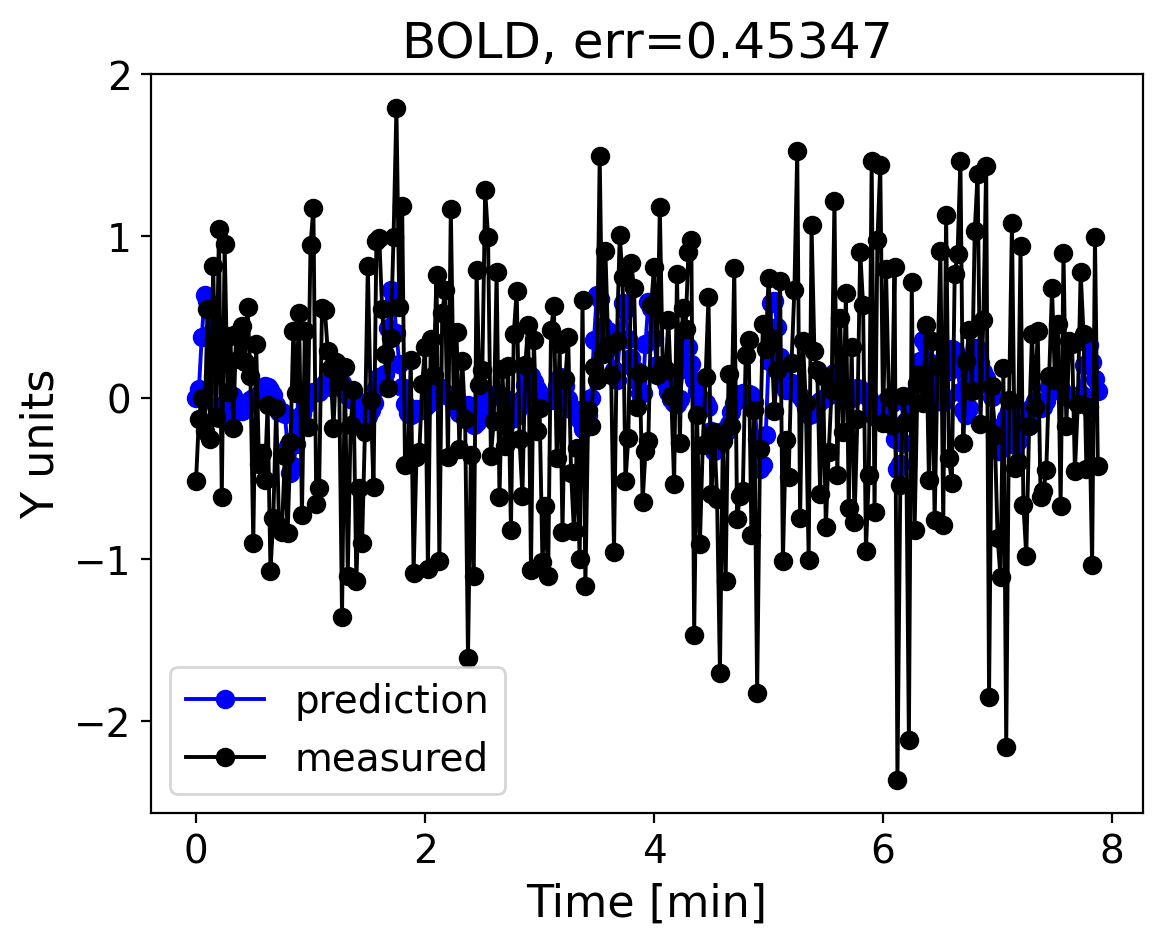

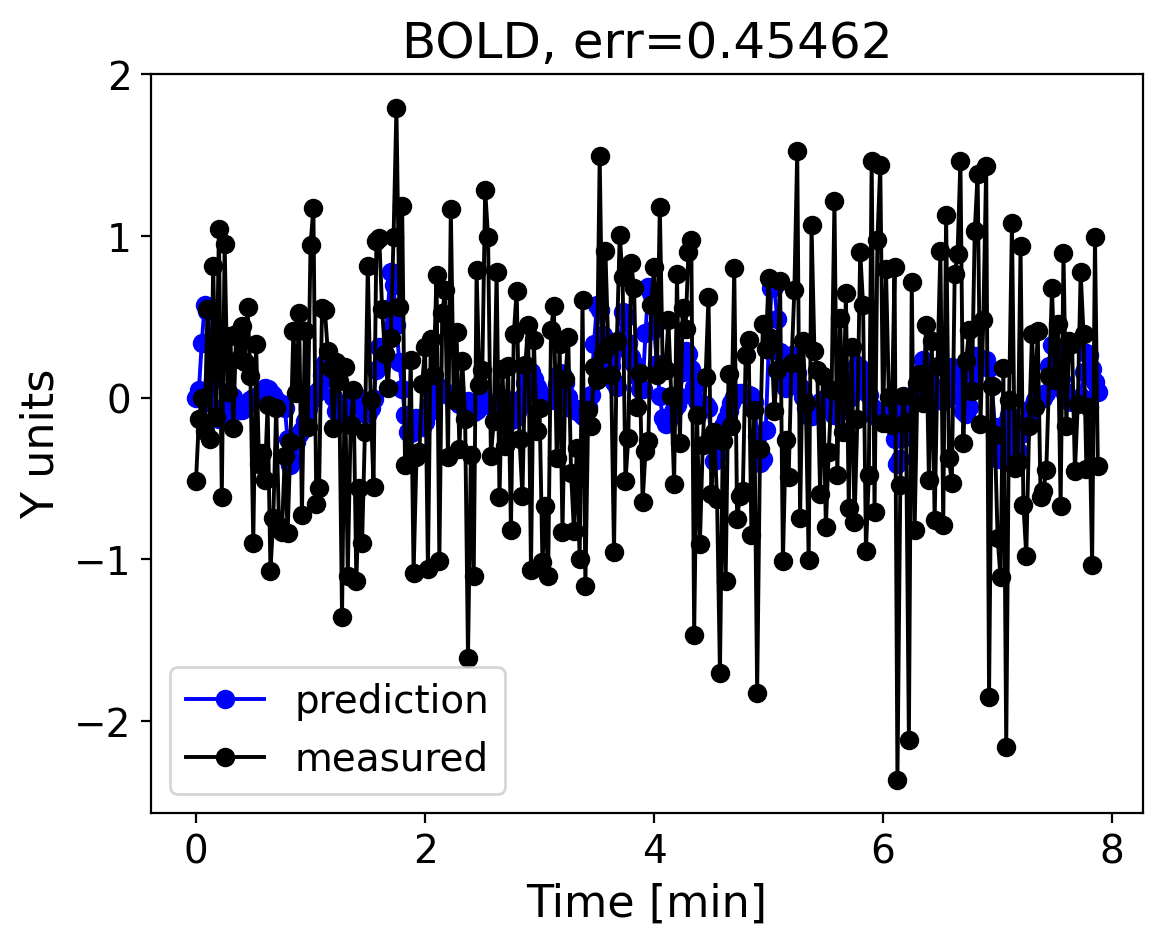

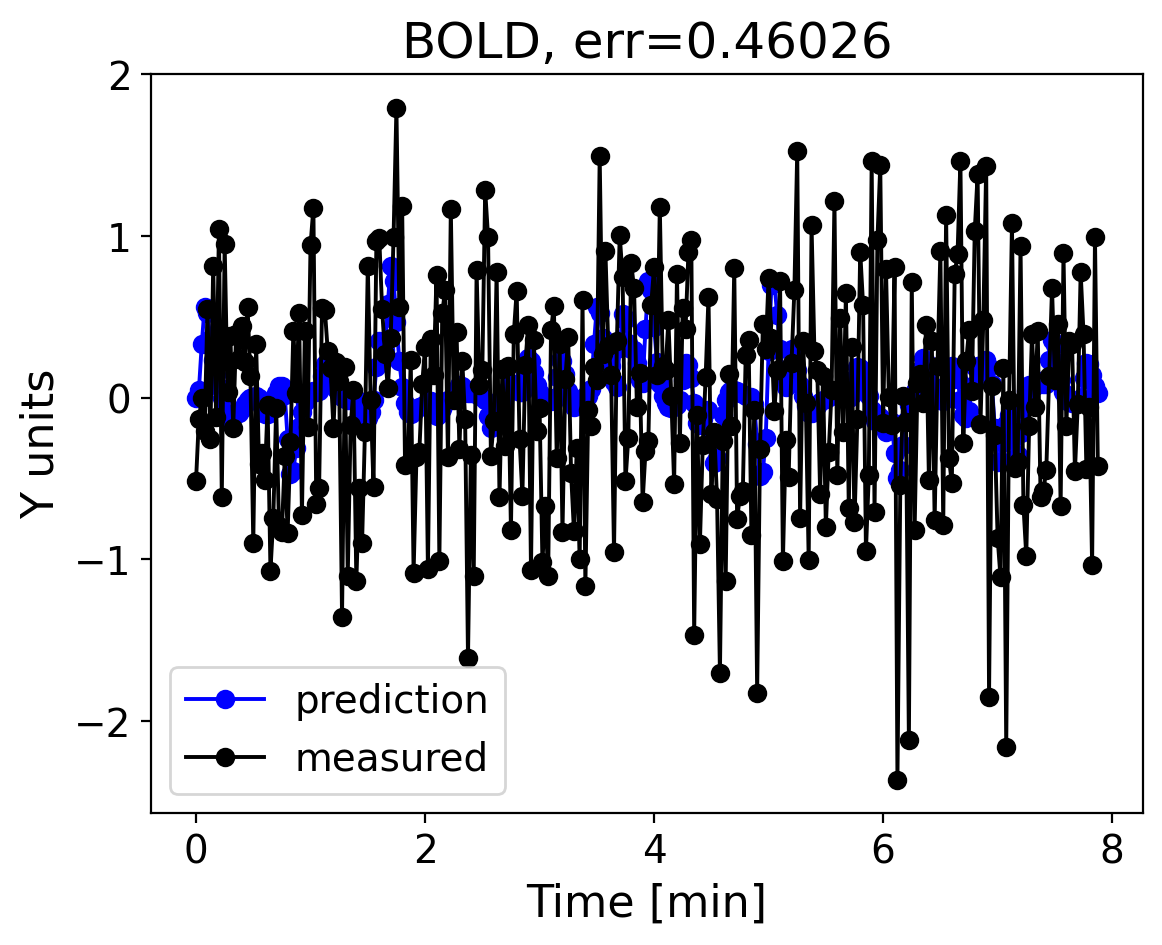

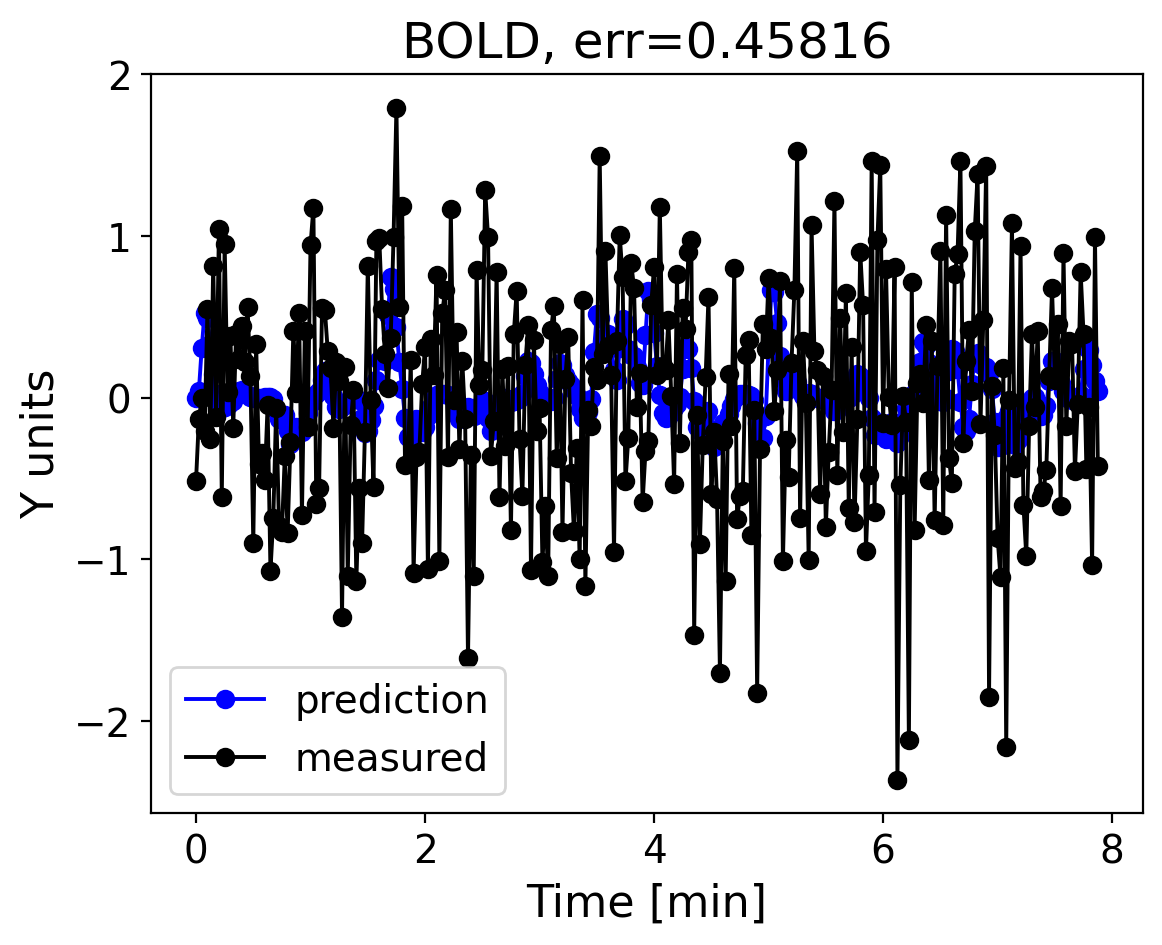

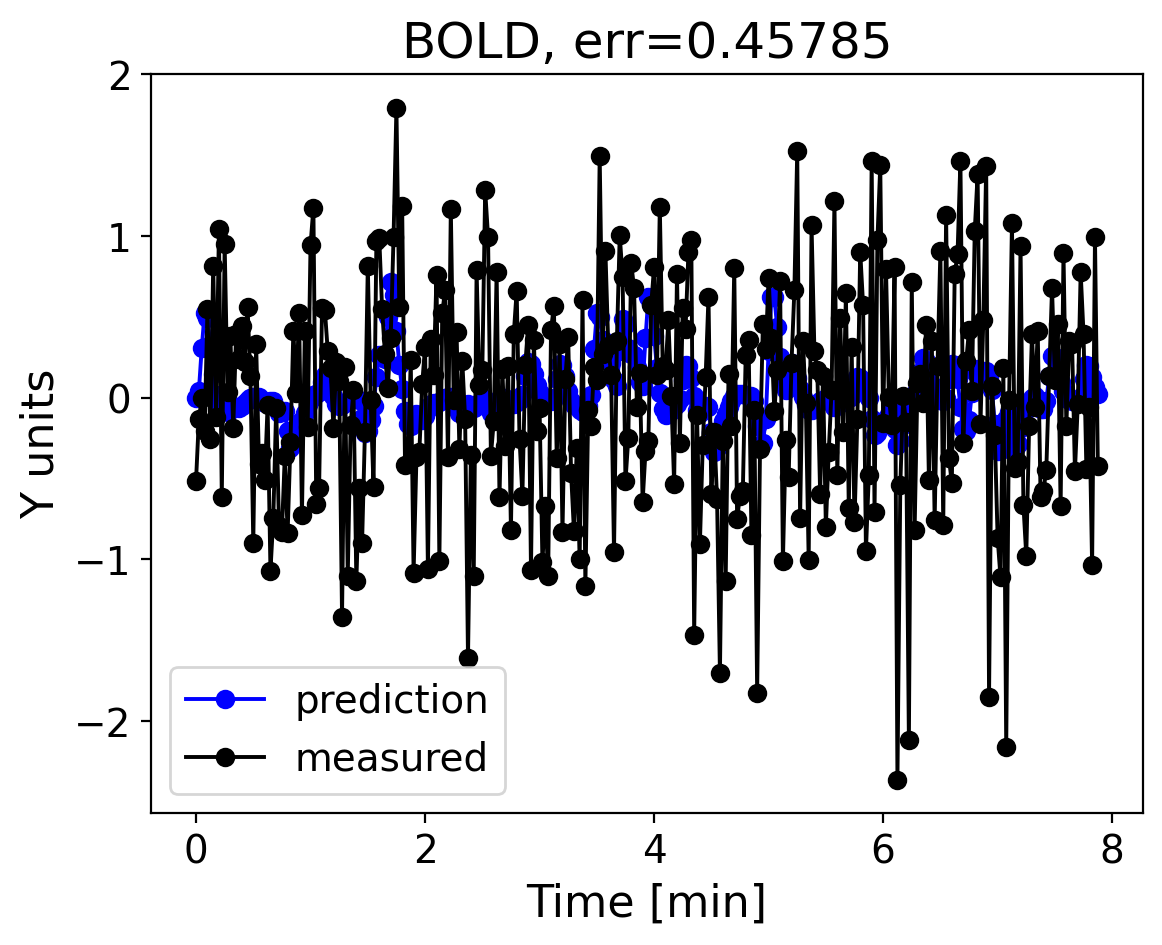

In [22]:
for i in range(optimization_iterations):
    BOLD_predicted = single_iteration_BOLD(weights_optimized_vec[i])
    err_val = err_optimized_vec[i]

    tit_label = "BOLD, err=" + str(np.round(err_val, 5))
    
    # Visualizing
    plt.plot(timeaxis_min, BOLD_predicted, marker="o", c="b", label = "prediction")
    plt.plot(timeaxis_min, BOLD_measured_voxel1, marker="o", c="k", label = "measured")
    
    plt.title(tit_label)
    plt.xlabel("Time [min]")
    plt.ylabel("Y units")
    plt.legend()
    plt.show()


It is hard to visualize what is happening when I overlay the BOLD predicted and BOLD measured. So I will plot a single graph for every weight that's associated to a given frequency. Is there any weight that is high compared to the rest? Is there nay evident pattern?

In [66]:
optimization_iterations

10

In [70]:
len(weights_optimized_vec[0])

18

Plot the weights of every channel after optimization


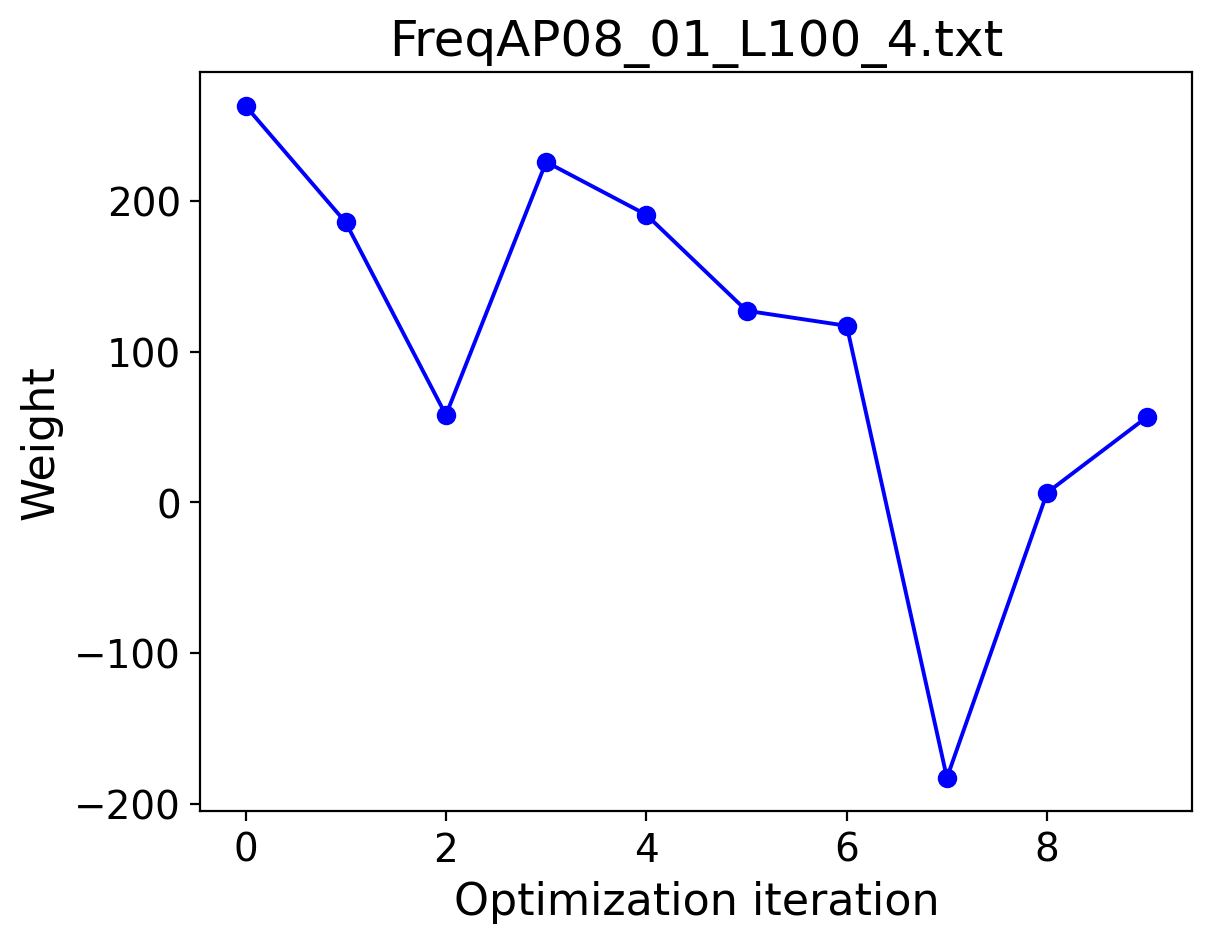

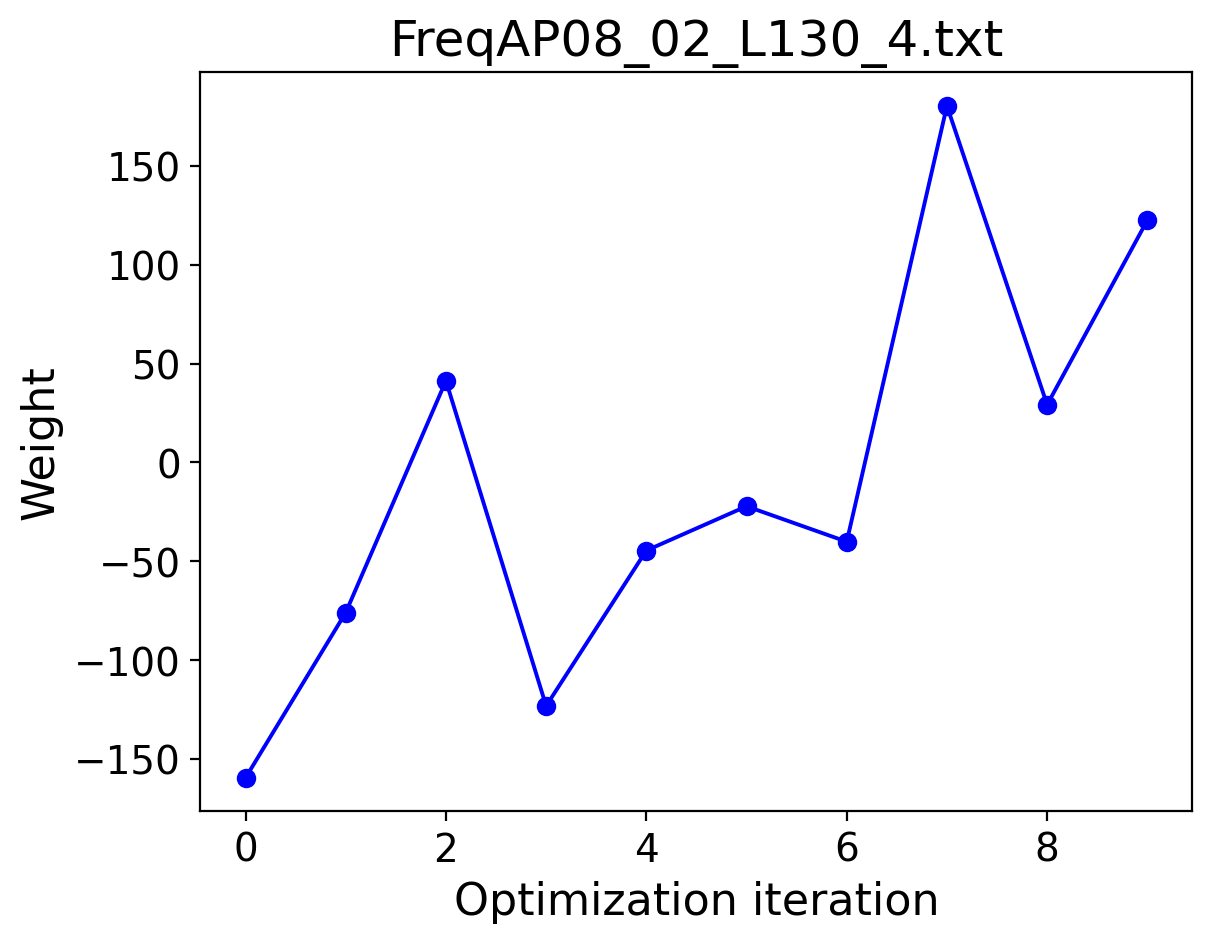

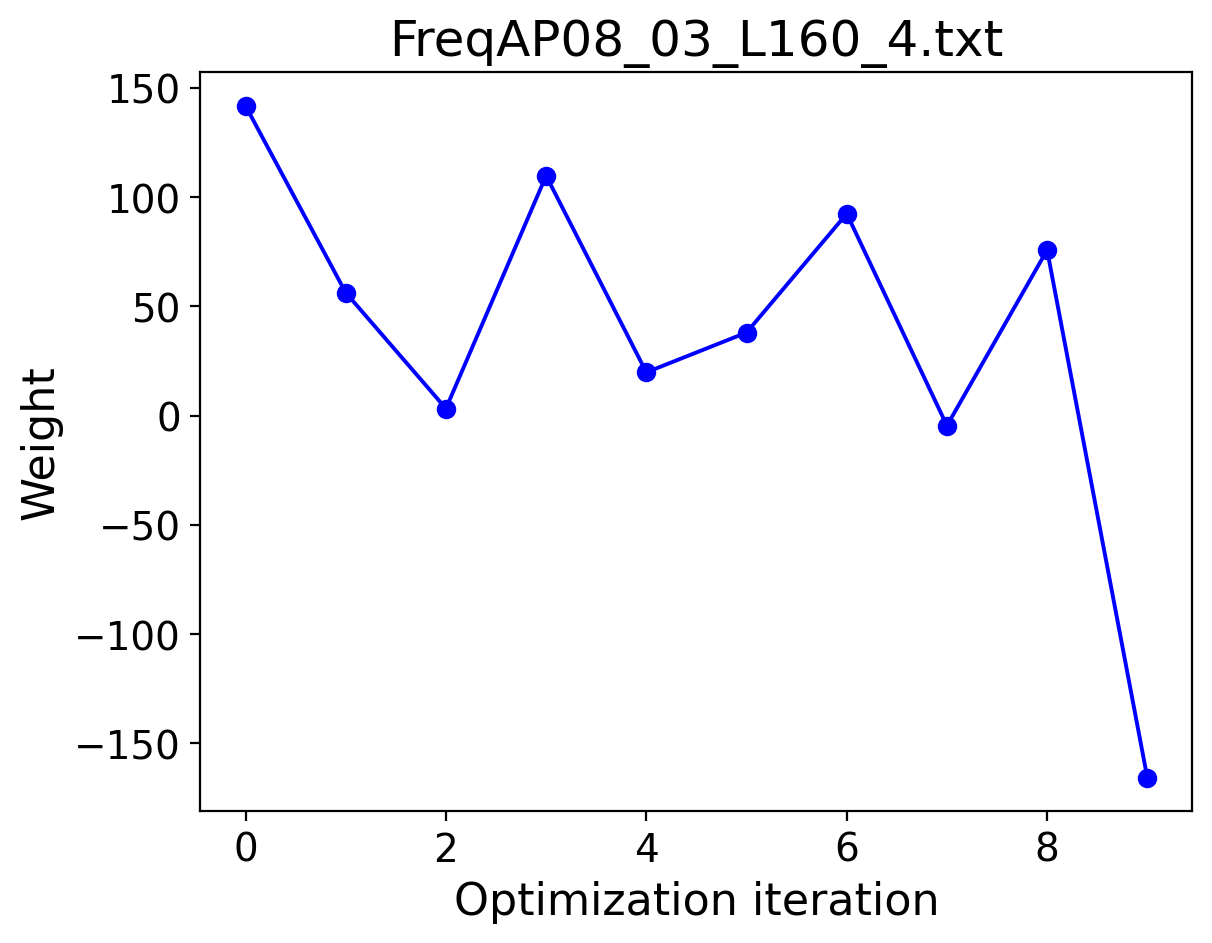

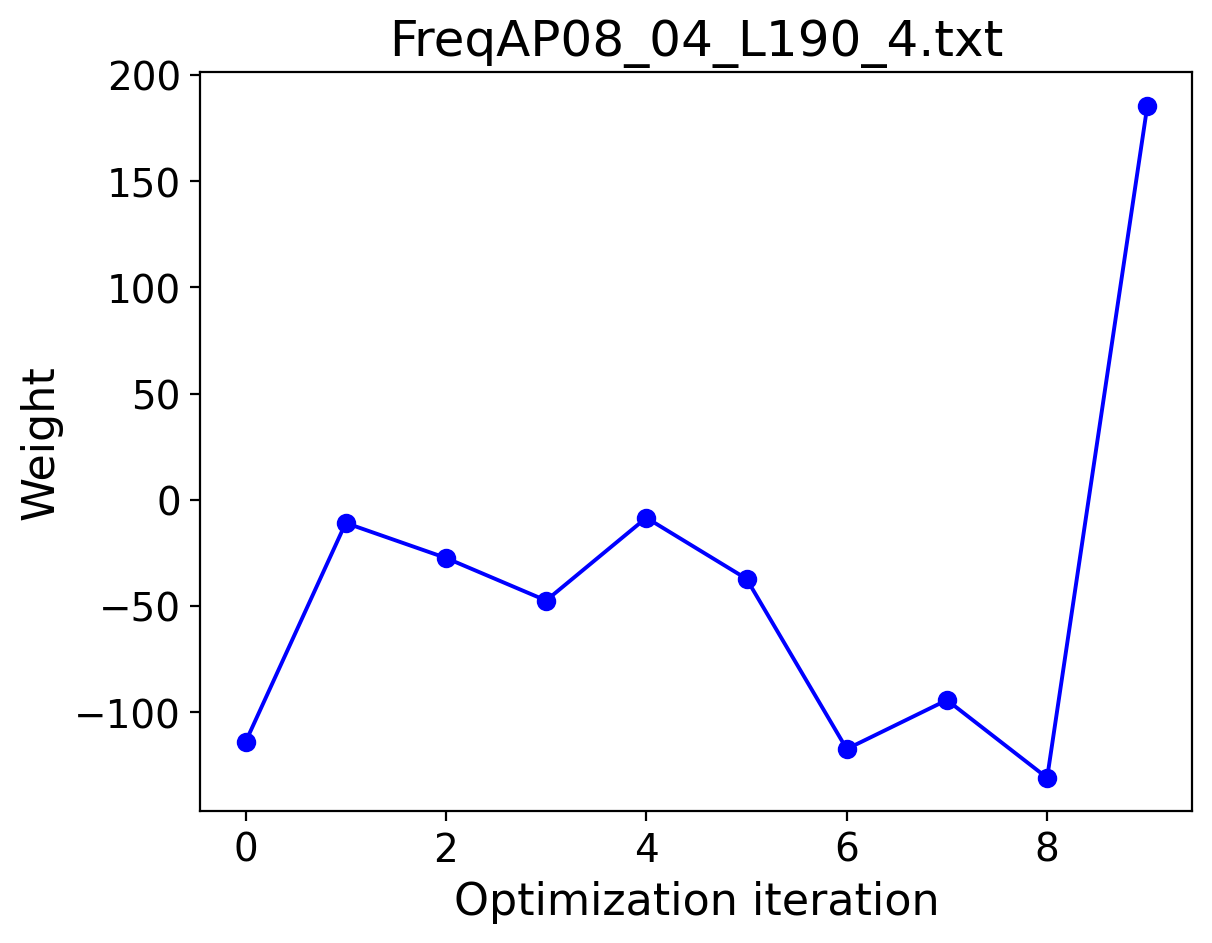

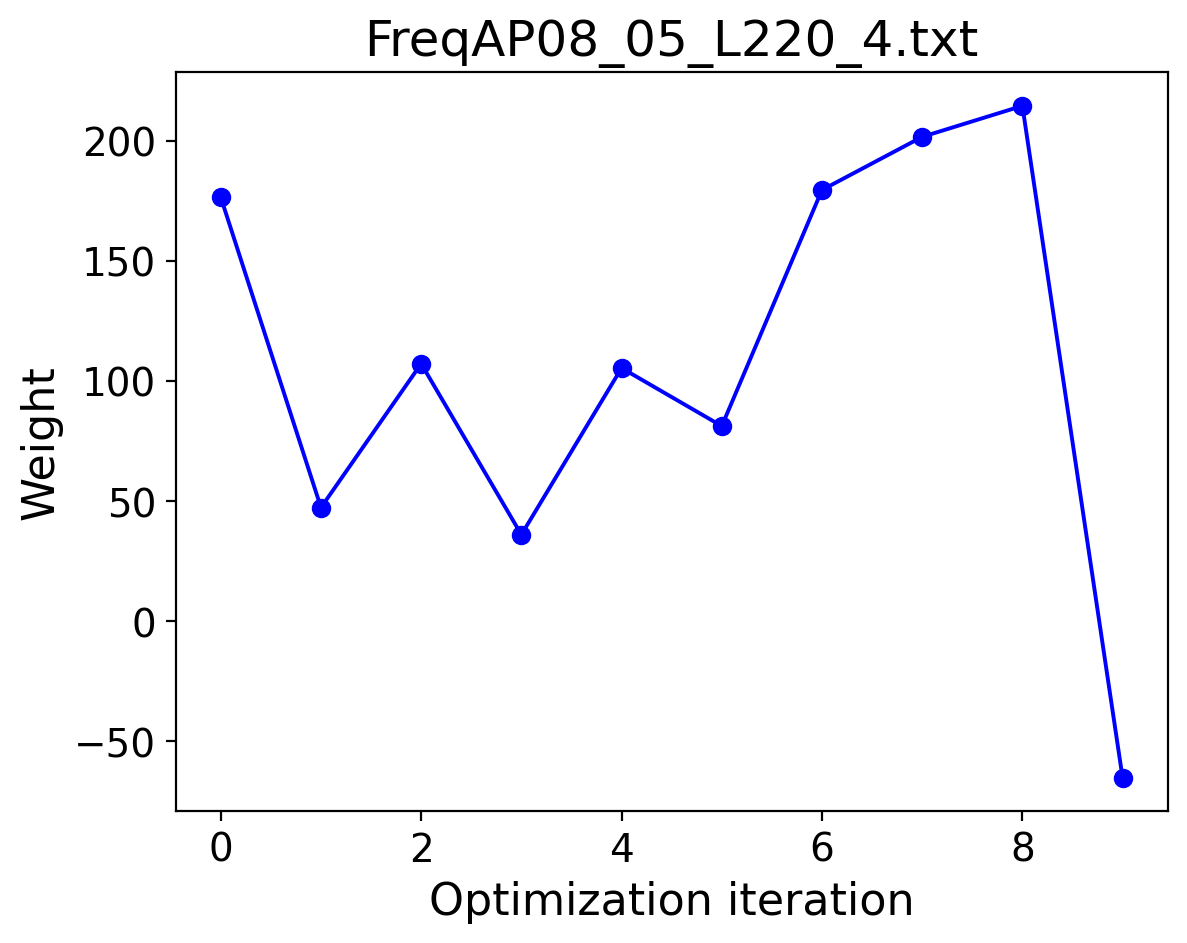

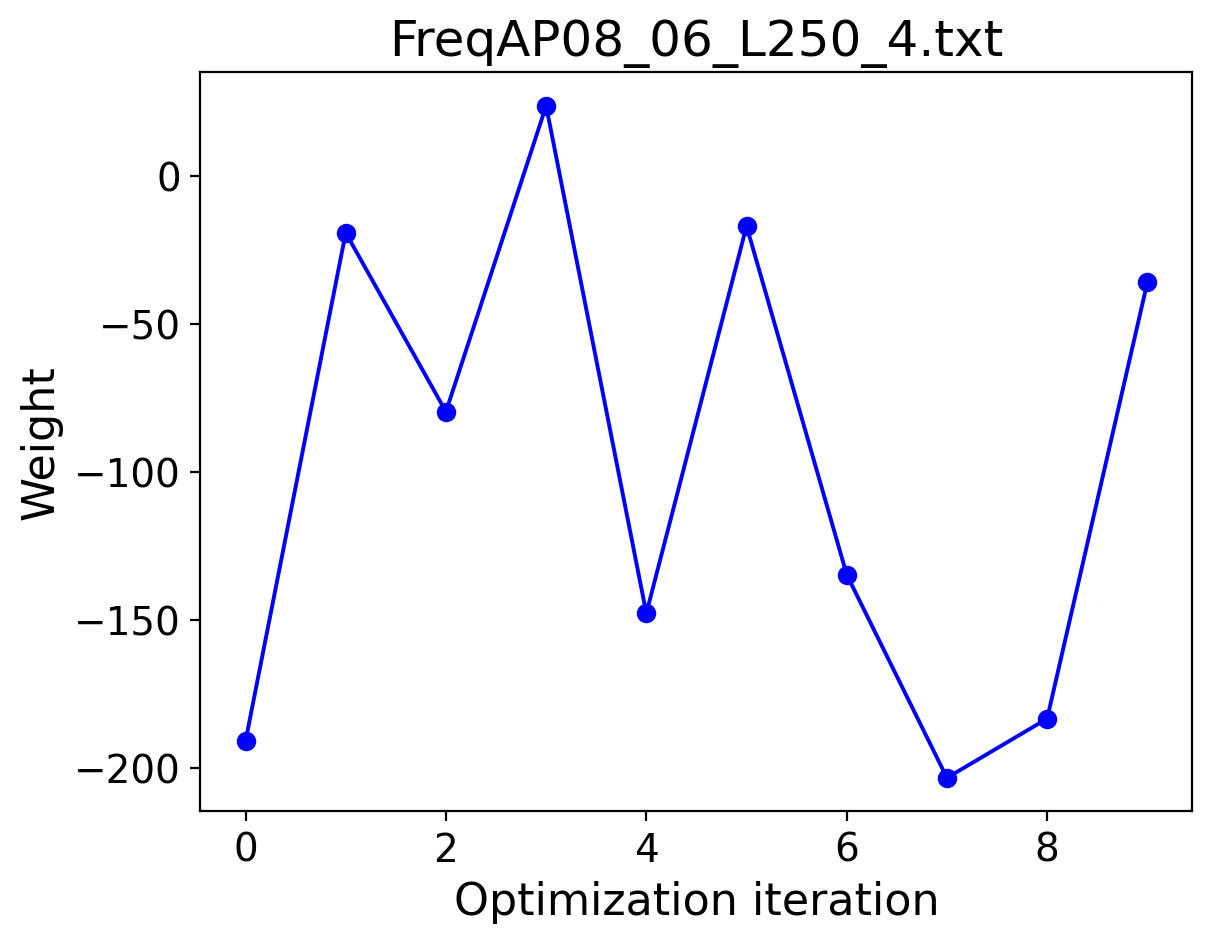

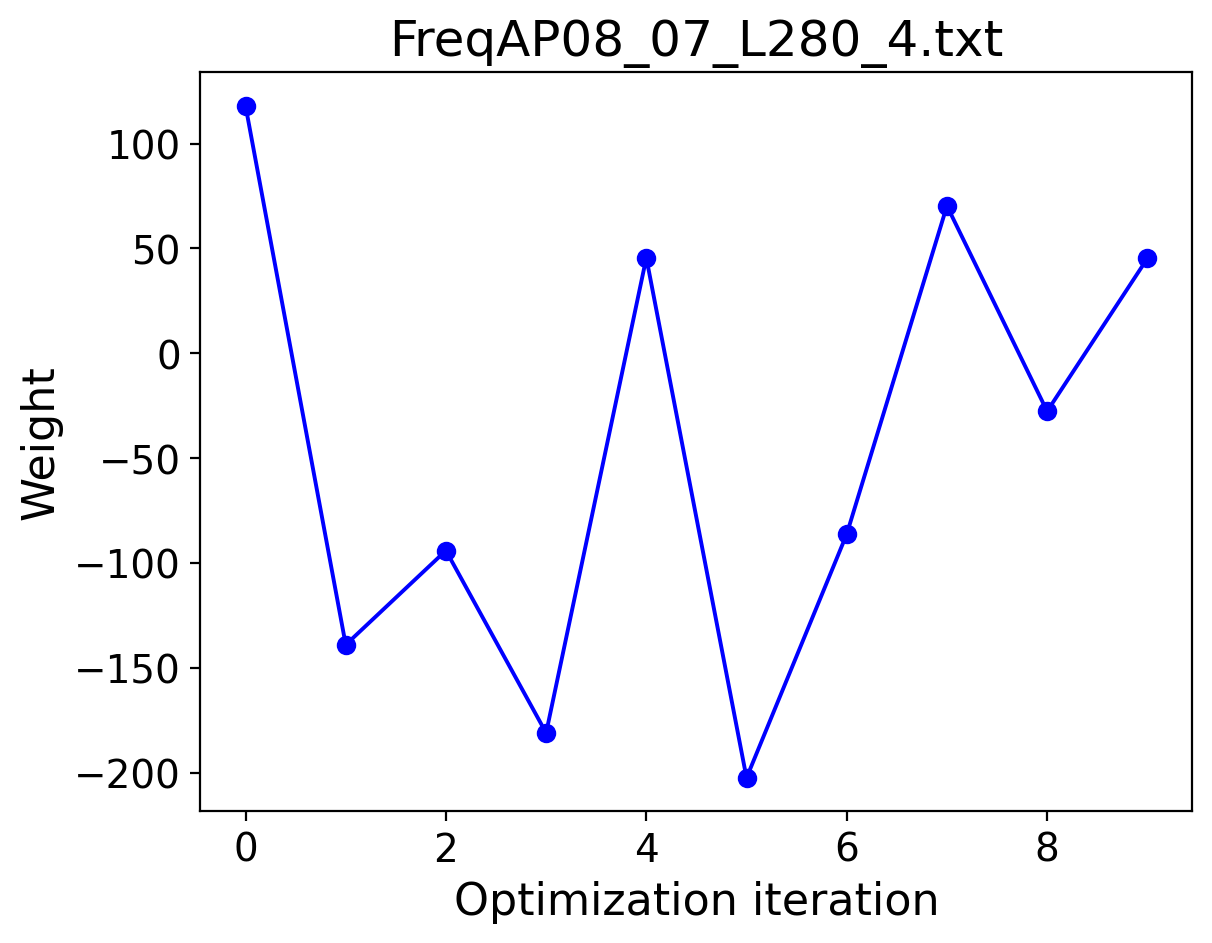

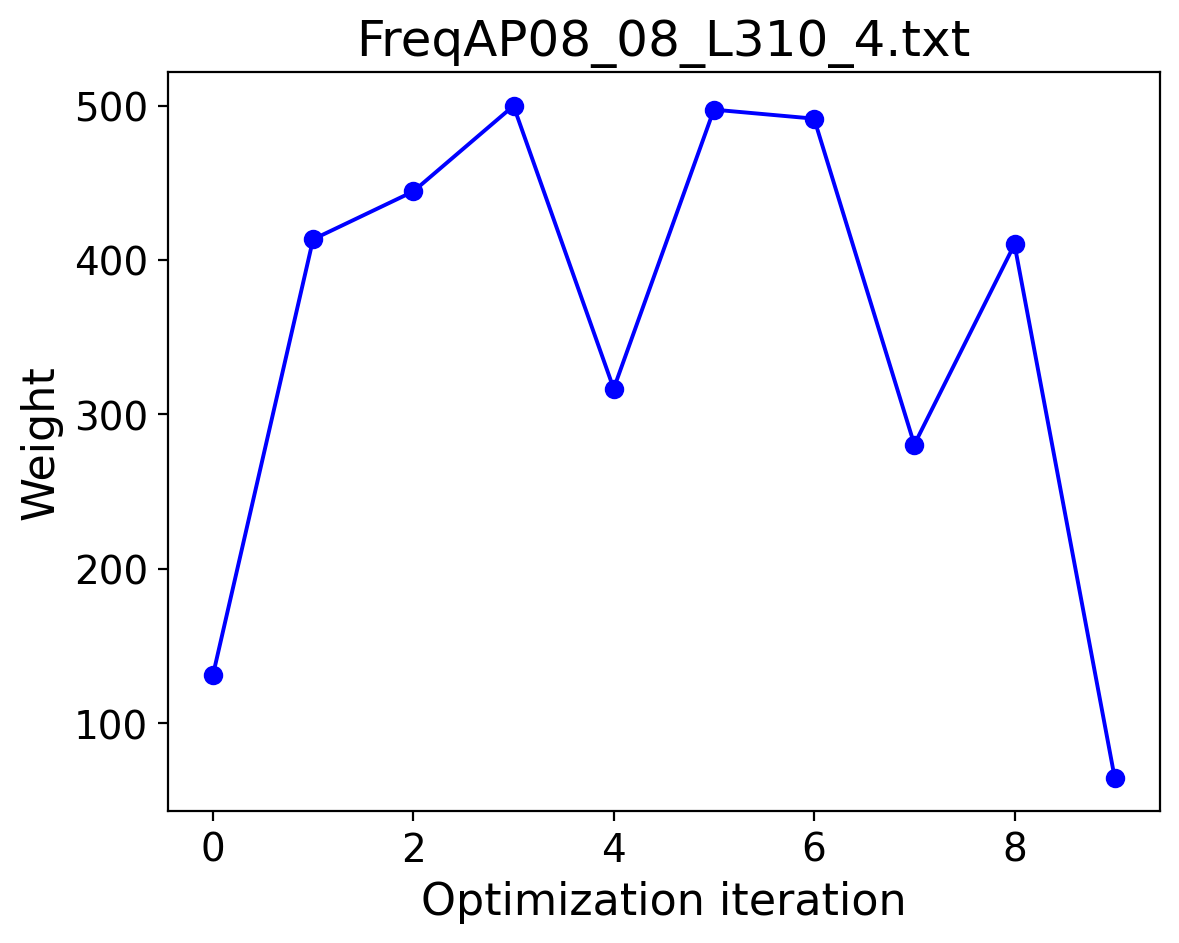

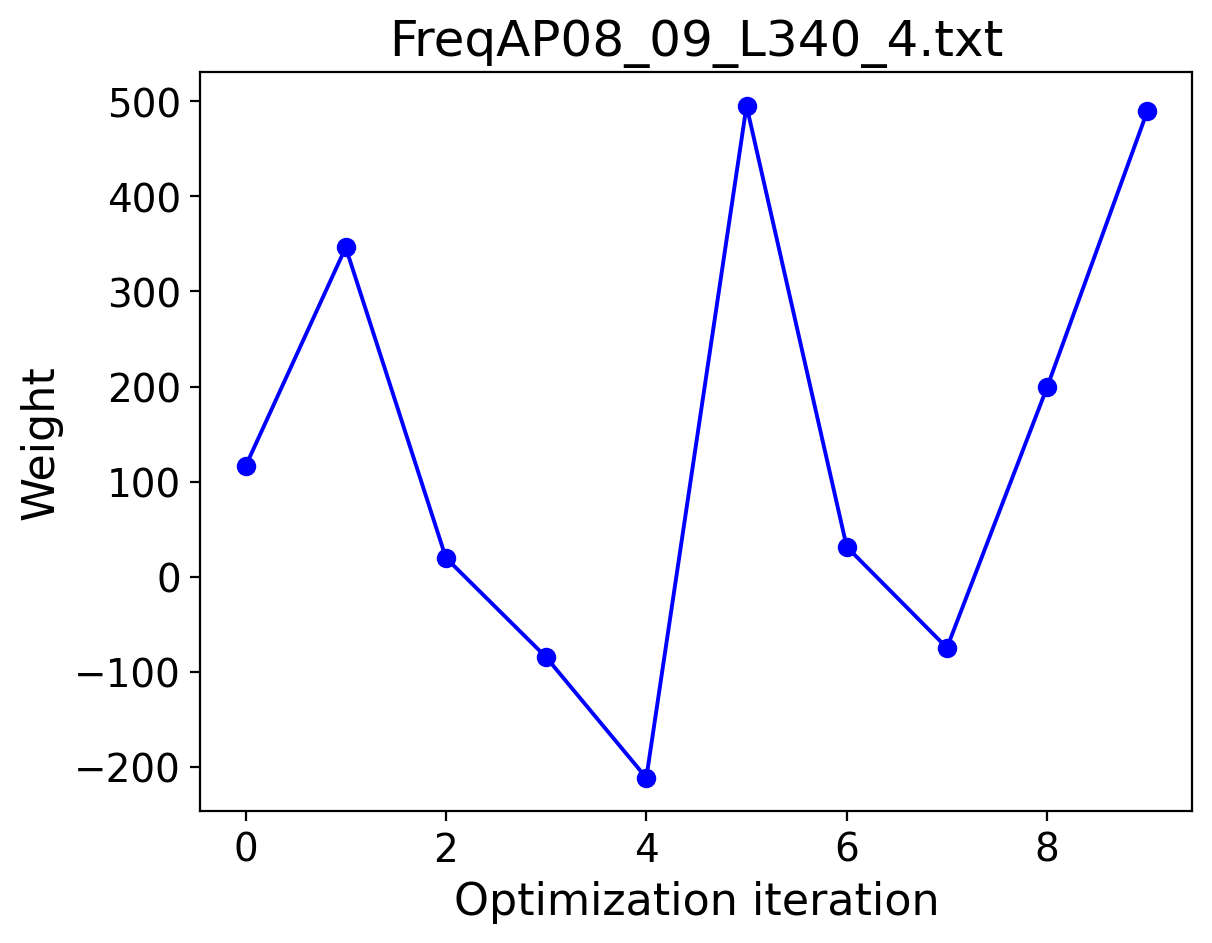

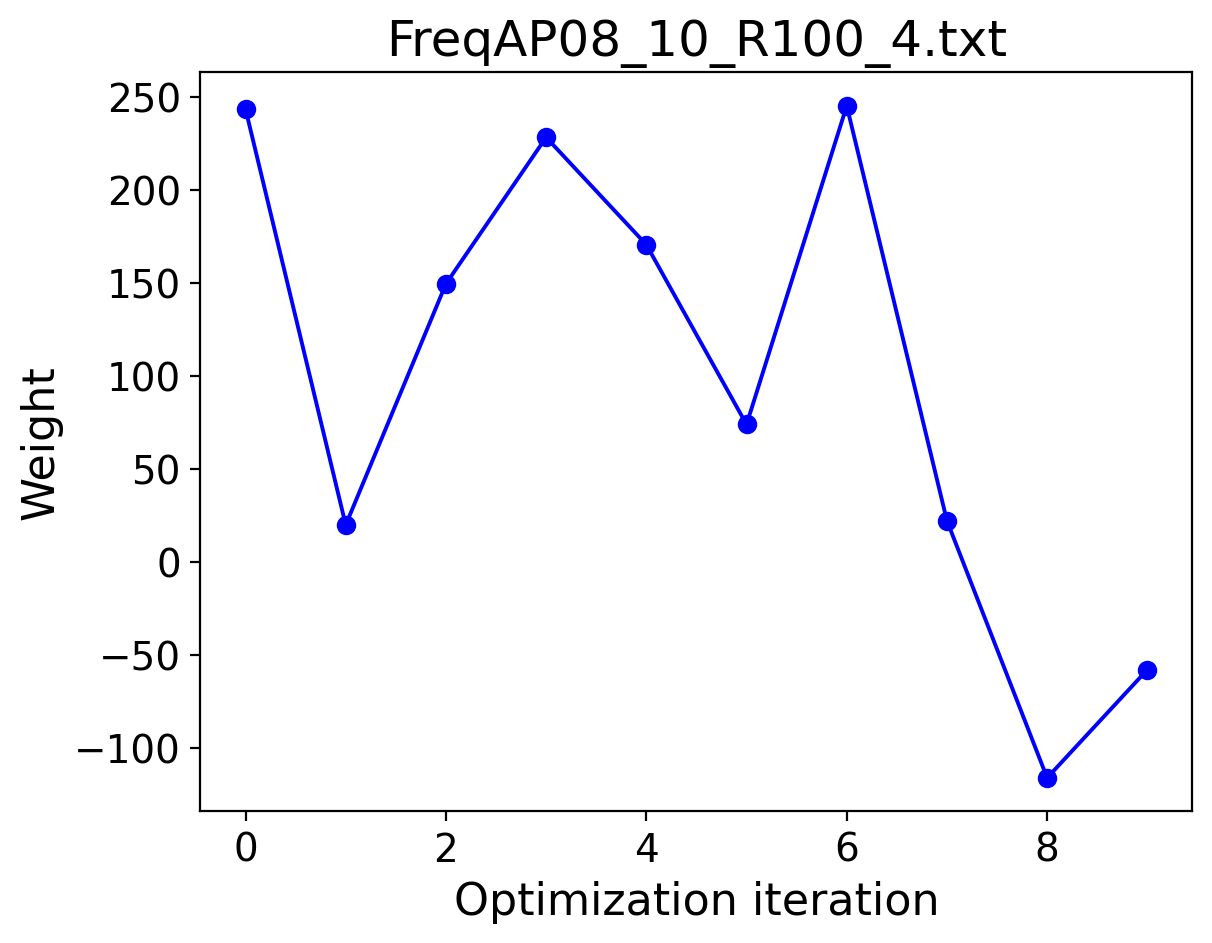

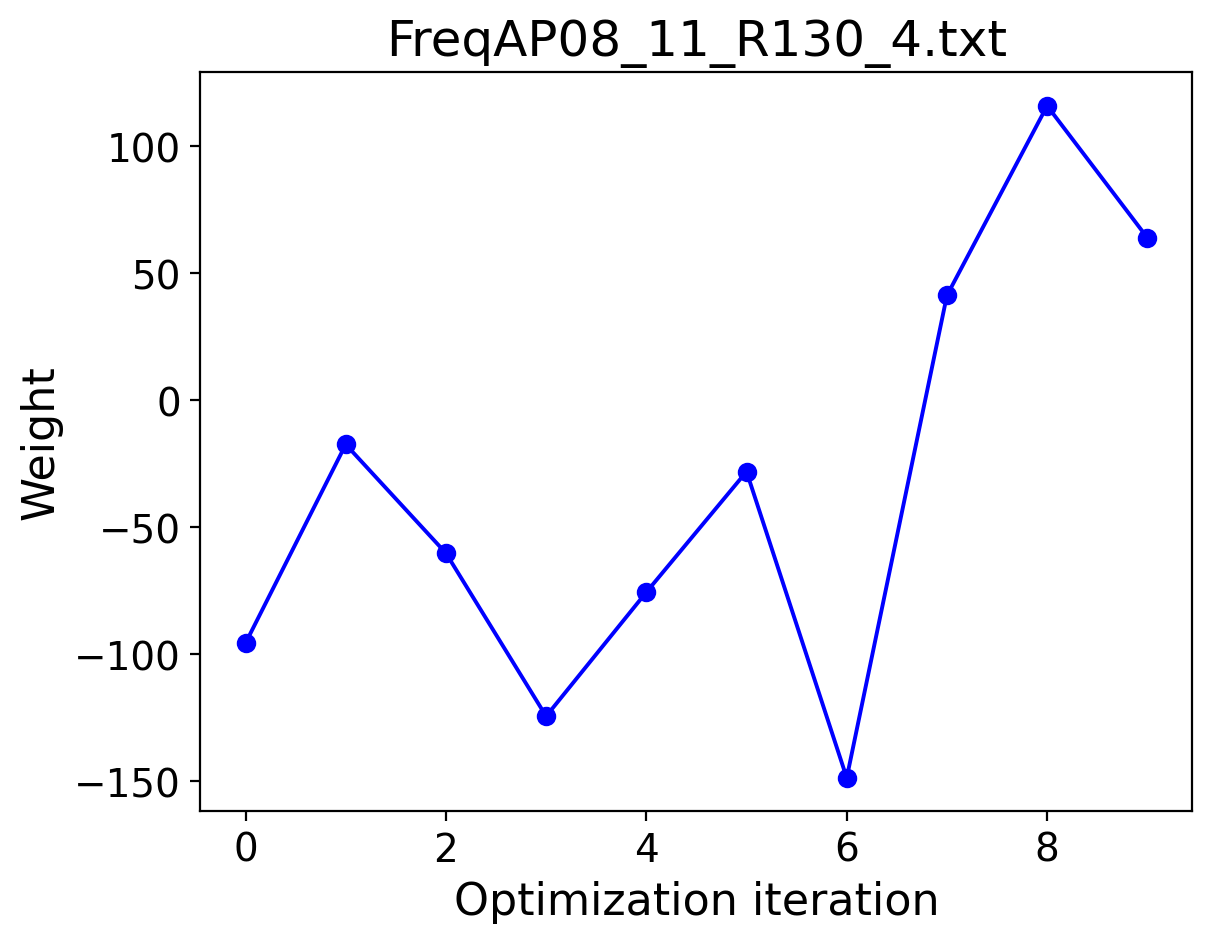

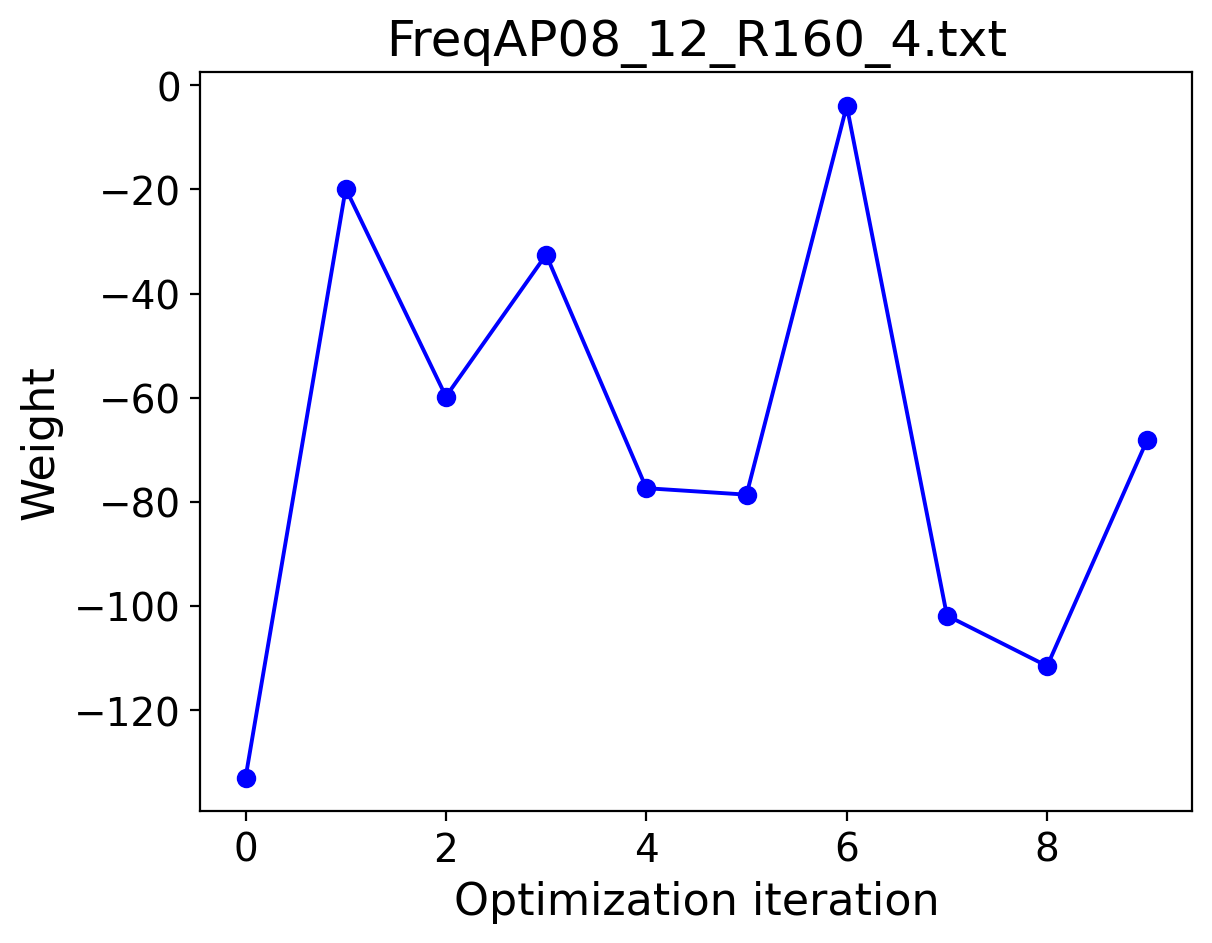

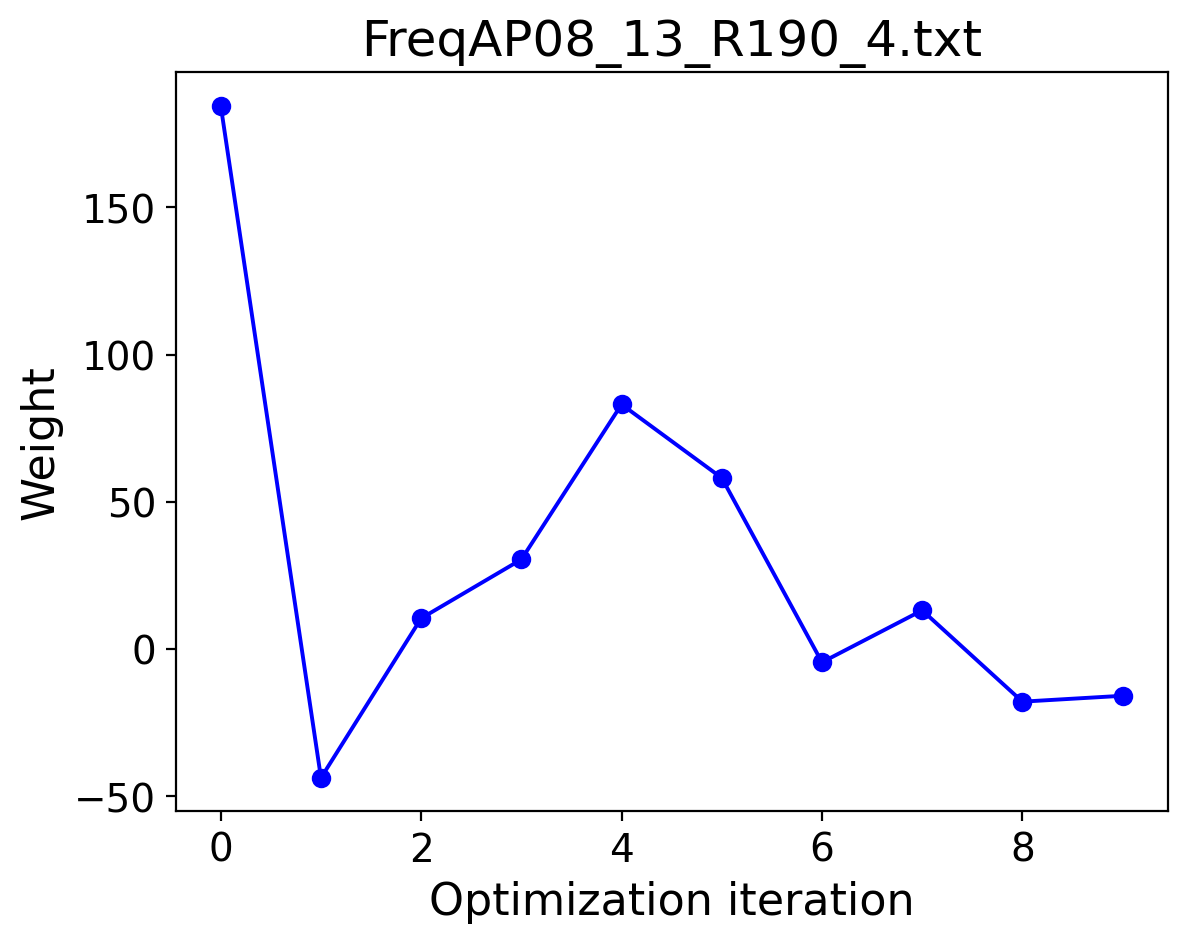

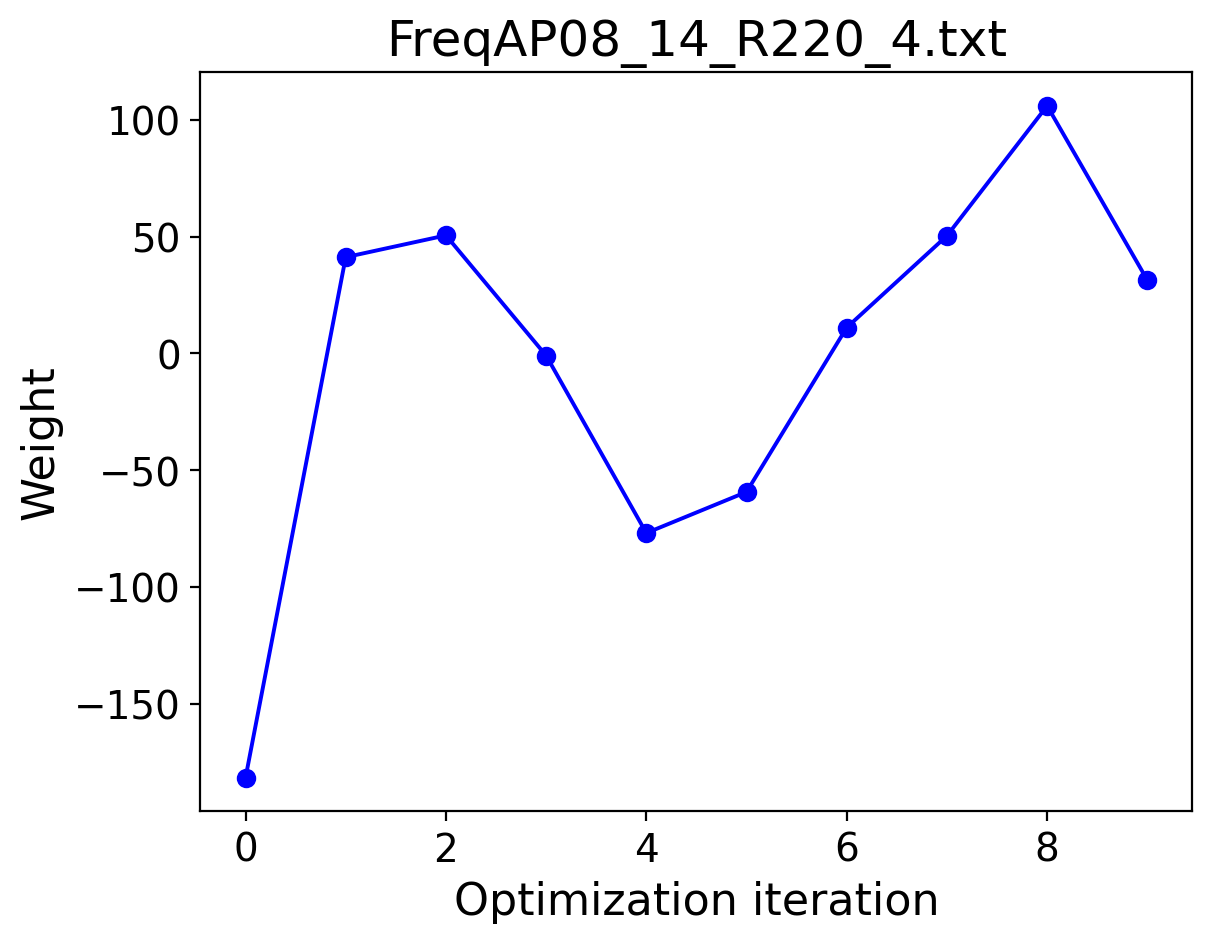

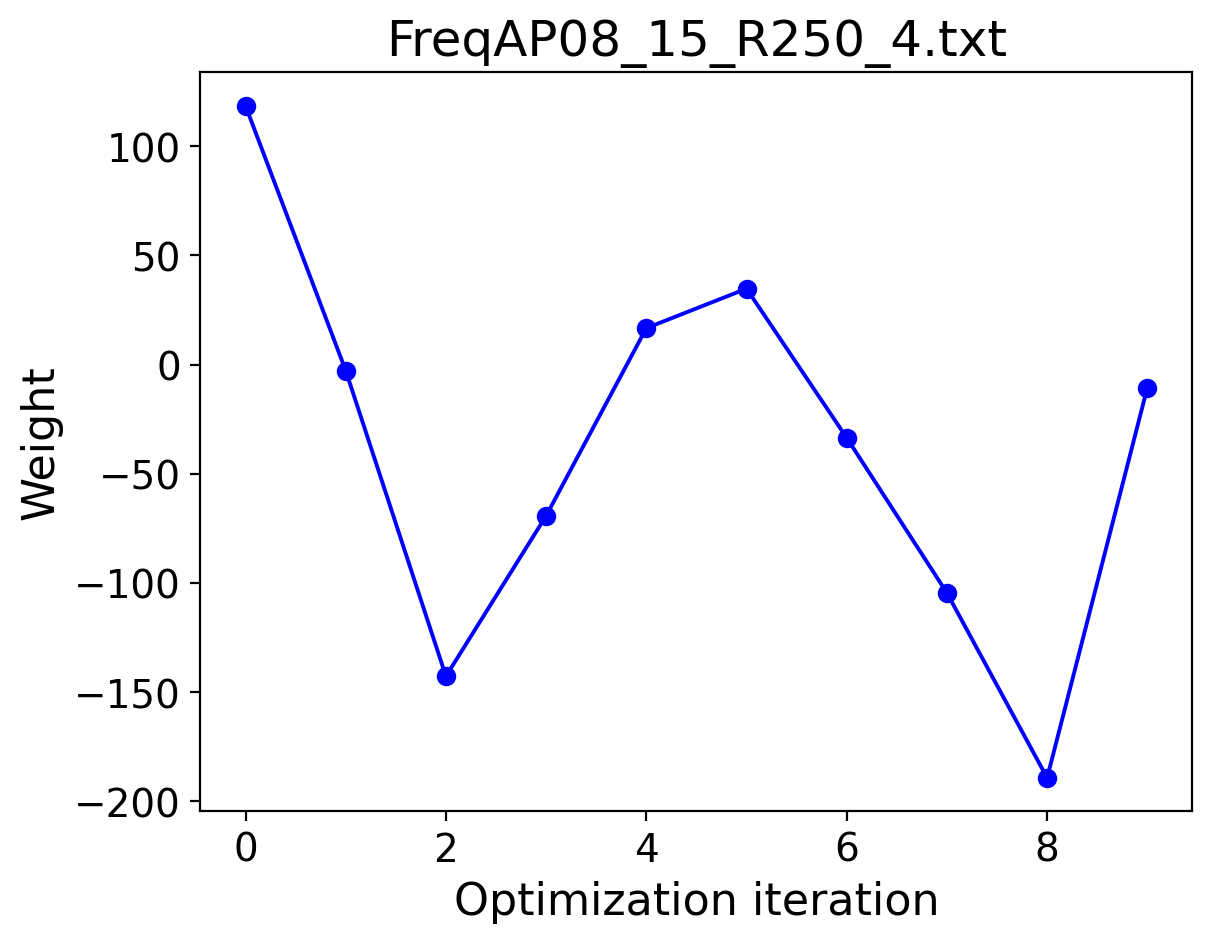

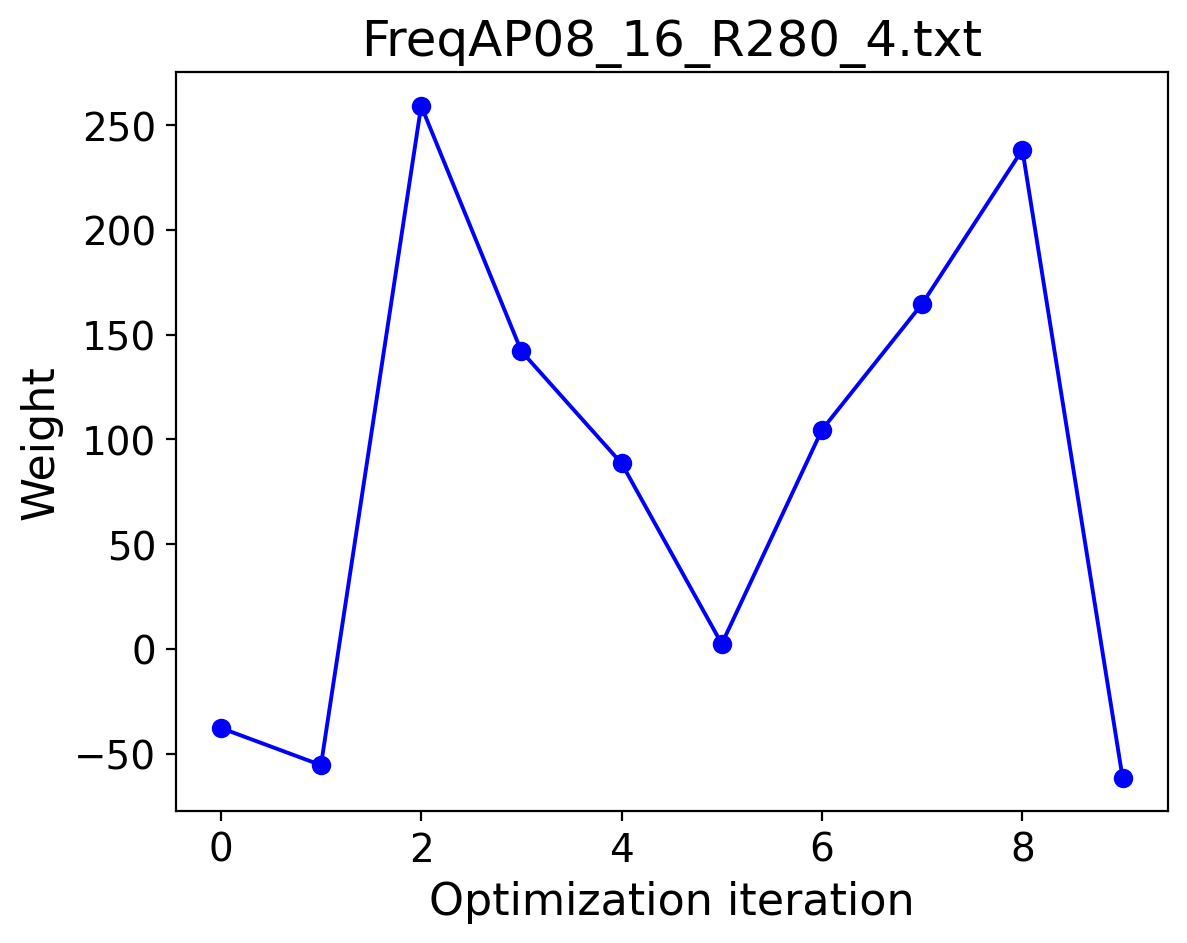

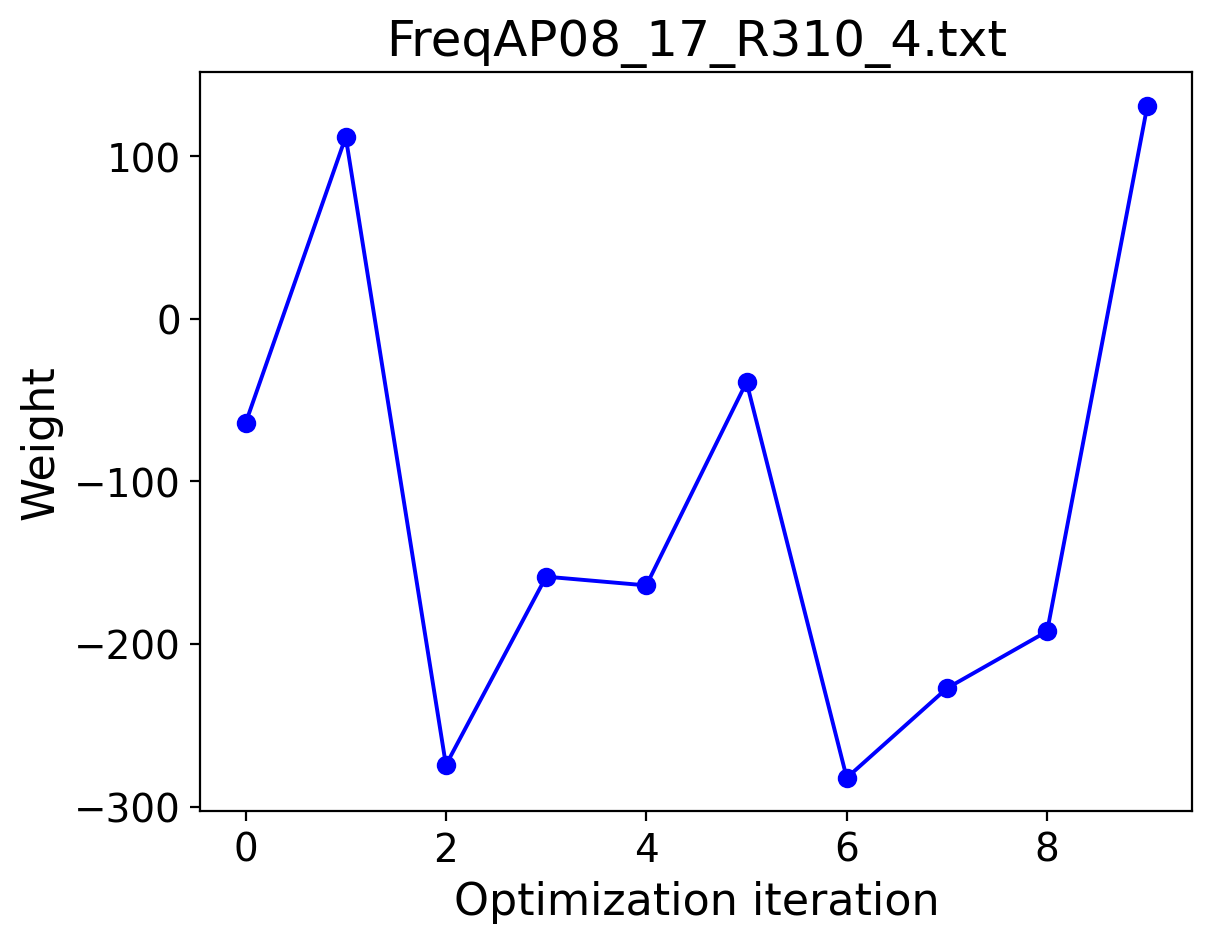

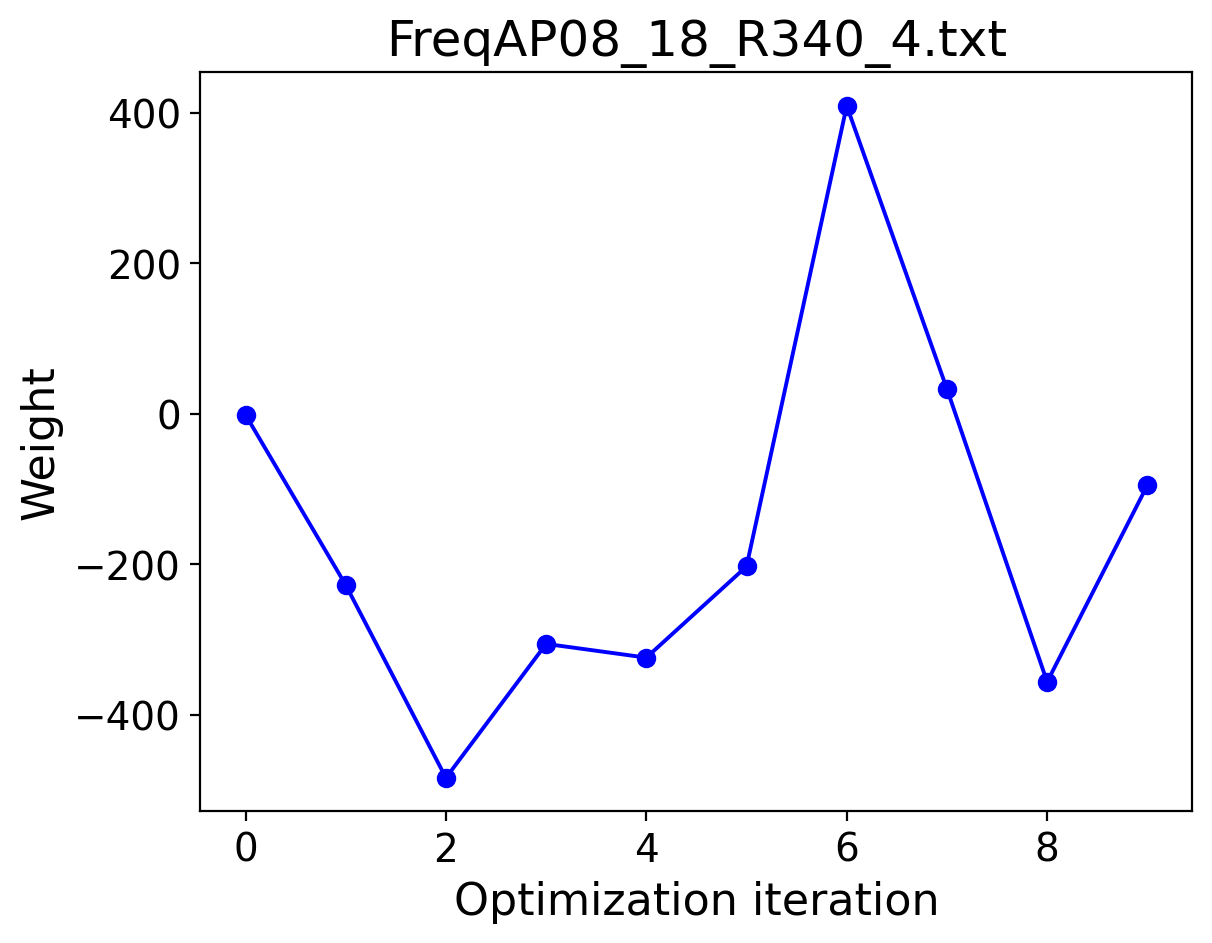

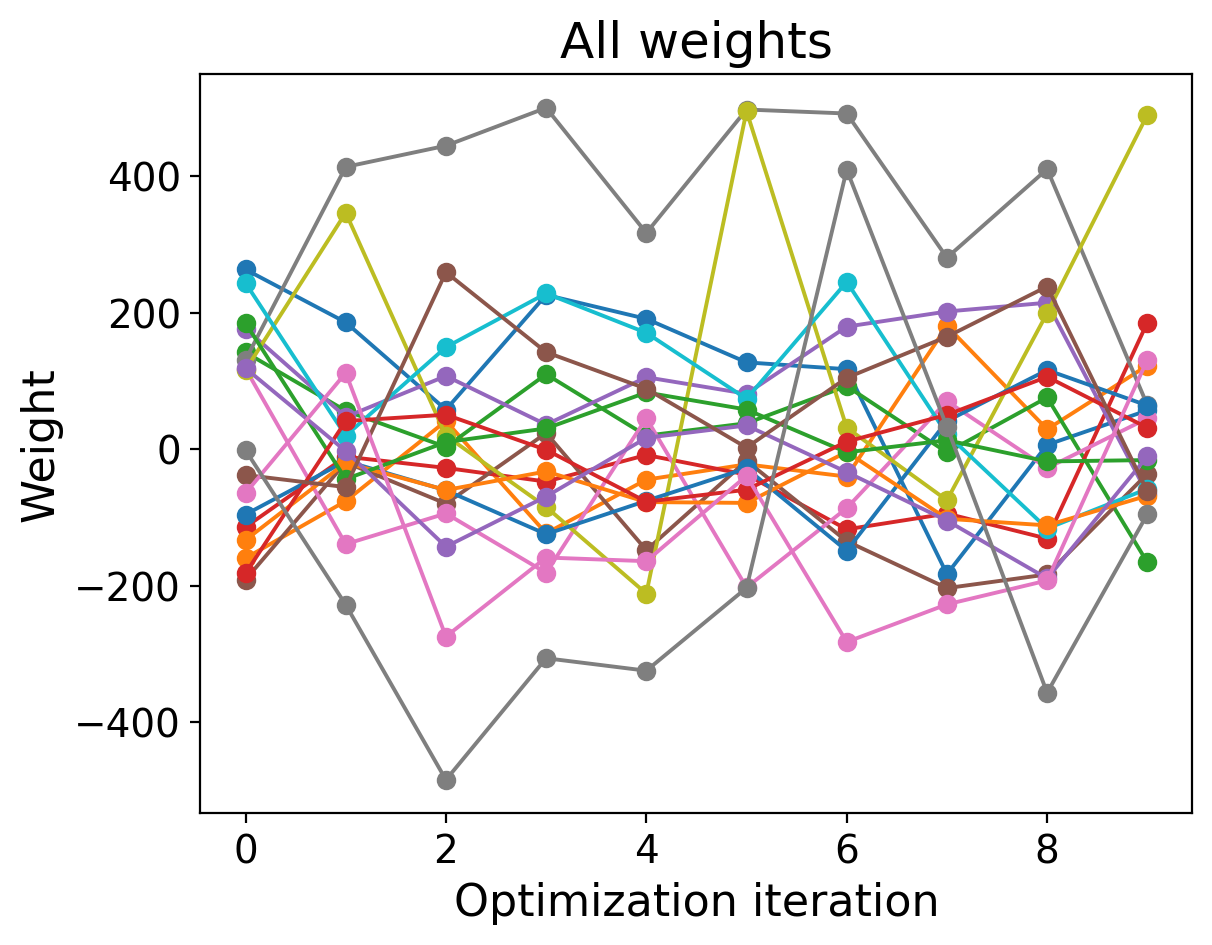

In [80]:
print("Plot the weights of every channel after optimization")
for weight_i in range(n_weights): #18 iterations because of 18 weights
    vec = [weights_optimized_vec[opt_i][weight_i] for opt_i in range(optimization_iterations)]# vector of 10 entries
    # Visualizing
    plt.plot(vec, marker="o", c="b")
    # plt.plot(timeaxis_min, BOLD_measured_voxel1, marker="o", c="k", label = "measured")
    
    tit_label = files_cond4[weight_i]
    plt.title(tit_label) # label i
    plt.xlabel("Optimization iteration")
    plt.ylabel("Weight")
    # plt.legend()
    plt.show()


for weight_i in range(n_weights): #18 iterations because of 18 weights
# Visualizing
    plt.plot([weights_optimized_vec[opt_i][weight_i] for opt_i in range(optimization_iterations)],
         marker="o")

plt.title("All weights") # label i
plt.xlabel("Optimization iteration")
plt.ylabel("Weight")
plt.show()

# Is there a way to make this code run faster, more efficient??

Does the `scipy.optimize_least_squares` option achieve the same result as the PyBADS optimization routine?

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

# Before going to analyzing what is happening with other voxels, understand what is happening at the single voxel level.
Plot the channel's weights for all the optimized routines.
Can you increasae the number, instead of 5 random initial locations, make them at least 20.


# If I optimize for other voxels, is the lowest the error can go also around 0.45??



# Is there some temporal correlation or is all of this noise? If I were to permute the time indices across time with the same BOLD values, would the error go up?? That is, shuffle the data. What happens to the fitting? I'd expect it to be worse.

The answers to these questions could be left in the gamer laptop running all night :)